In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('../data/df_01.csv')

In [5]:
lista = list(df['CPF_CNPJ_Des'])
lista

[5291847964,
 5668336972,
 5668336972,
 5269738970,
 3970921996,
 35442751987,
 4938853906,
 61652717900,
 5451662924,
 5451662924,
 5451662924,
 5451662924,
 44767927900,
 7213760963,
 1881864928,
 663340985,
 8210284991,
 6070065875,
 5947312913,
 3594546900,
 3594546900,
 969279922,
 2799445942,
 2799445942,
 2799445942,
 30741823934,
 65850700978,
 5365484983,
 671829920,
 55521495991,
 55521495991,
 9185454982,
 50046330968,
 78093945920,
 31691510963,
 62639897934,
 2291702939,
 3068239931,
 25318578934,
 25318578934,
 1989363970,
 1989363970,
 40358160944,
 40358160944,
 70051321904,
 80379419904,
 6321160997,
 5956762942,
 48254452920,
 53004760991,
 5211577000166,
 6581044970,
 8442230939,
 14255645850,
 934180946,
 934180946,
 4323422903,
 4323422903,
 27844722991,
 27844722991,
 27844722991,
 30742897915,
 34055223900,
 34055223900,
 47092254949,
 48050814904,
 4607452980,
 96514817904,
 9451008845,
 8710708987,
 2057962903,
 2057962903,
 2057962903,
 3607819939,
 3607819939

In [6]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.classes.function import path_weight
from tqdm import tqdm



In [7]:

def get_concessions(list_nodes: list,emp_type: dict)-> int: 
  # As concessões são todas emps marcadas como MANEJO,1
  # (fonte legal e extratores de madeira)

  count = 0
  for node in list_nodes:
    if emp_type[node] == 'MANEJO':
      count+=1

  return count

def get_sink_nodes(graph: nx.graph, emp_type: dict)-> dict:
  # If node is marked as FINAL, he is a sink
  # It is the final destination of the timber chain

  nodes = {}
  for node in graph.nodes():
    if emp_type[node] == 'FINAL':
      nodes[node] = 1
      continue

    # we consider sink nodes as final nodes or nodes that only transports to other final nodes
    not_sink = False
    for edge in graph.edges(node):
      if emp_type[edge[1]] != 'FINAL':
        not_sink=True

    if not not_sink:
      nodes[node] = 1

  return nodes

def get_timberflow(graph: nx.graph,emp_type: dict) -> None:
  
  sink_nodes = get_sink_nodes(graph, emp_type)

  total_in = 0
  total_out = 0

  # For all edges in the graph
  # 1. sum the volume of input (from MANEJO types)
  # 2. sum the volume of output (from FINAL types)
  for edge in graph.edges():
    if emp_type[edge[0]] == 'MANEJO':
      total_in += path_weight(graph, [edge[0],edge[1]], weight='Volume')
    elif edge[1] in sink_nodes:
      total_out += path_weight(graph, [edge[0],edge[1]], weight='Volume')

  print(f'Inflow Vol(m3): {total_in} \nOut Vol(m3): {total_out} \nProportion: {total_out/total_in}')

In [8]:
def convert_id_to_str(df: pd.DataFrame )-> pd.DataFrame:
    """Converte  as colunas de CPF_CNPJ_Rem e CPF_CNPJ_Des
    para str

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    df['CPF_CNPJ_Rem'] = df['CPF_CNPJ_Rem'].astype(str)
    df['CPF_CNPJ_Des'] = df['CPF_CNPJ_Des'].astype(str)
    
    return df

In [46]:

# transportes_junho = pd.read_csv('../data/df_06.csv')
transportes_julho = pd.read_csv('../data/df_07.csv')
transportes_agosto = pd.read_csv('../data/df_08.csv')
transportes_setembro = pd.read_csv('../data/df_09.csv')
transportes_outubro= pd.read_csv('../data/df_10.csv')
transportes_novembro = pd.read_csv('../data/df_11.csv')
transportes_dezembro = pd.read_csv('../data/df_12.csv')

transportes_janeiro =  pd.read_csv('../data/df_01.csv')
transportes_feveiro = pd.read_csv('../data/df_02.csv')
transportes_marco = pd.read_csv('../data/df_03.csv')
transportes_abril = pd.read_csv('../data/df_04.csv')
transportes_maio = pd.read_csv('../data/df_05.csv')
transportes_junho = pd.read_csv('../data/df_06.csv')

tranporte_ano= pd.concat([transportes_janeiro,transportes_feveiro,transportes_marco,transportes_abril,transportes_maio, transportes_junho, transportes_julho, transportes_agosto, transportes_setembro, transportes_outubro, transportes_novembro, transportes_dezembro], ignore_index=True)





df_tran = tranporte_ano[['CPF_CNPJ_Rem', 'TpRem', 'CPF_CNPJ_Des', 'TpDes', 'Volume']]
df_tran= df_tran.groupby(['CPF_CNPJ_Rem', 'TpRem', 'CPF_CNPJ_Des', 'TpDes'])['Volume'].sum().reset_index()
df_tran = convert_id_to_str(df_tran)


#  Empresas do tipo Patio q_ue transportam para empresas do tipo pátio
df_pto = df_tran[(df_tran['TpRem'] == 'PTO_IBAMA') & (df_tran['TpDes'] == 'PTO_IBAMA')].rename(columns={'CPF_CNPJ_Rem': 'CPF_CNPJ'})
df_pto = df_pto.groupby('CPF_CNPJ')['Volume'].sum().reset_index()

nodes = set(df_tran['CPF_CNPJ_Rem']).union(set(df_tran['CPF_CNPJ_Des']))
nodes_pto = set(df_pto['CPF_CNPJ'])

#  Criando grafo
G = nx.DiGraph()
G.add_nodes_from(nodes)


# Cria as arestas com base nas transações e com peso = volume
edges = []
for row in df_tran.iterrows():
    # Ignora laços
    if str(row[1]['CPF_CNPJ_Rem']) != str(row[1]['CPF_CNPJ_Des']):
        edges.append((str(row[1]['CPF_CNPJ_Rem']), str(row[1]['CPF_CNPJ_Des']), {'Volume': row[1]['Volume']}))
G.add_edges_from(edges)



df_pto['Grau'] = df_pto['CPF_CNPJ'].apply(lambda x: G.degree(x))


Q1 = df_pto['Grau'].quantile(0.25)
Q2 = df_pto['Grau'].quantile(0.75)



emp_pto_degree = {}

for node in nodes_pto:
    emp_pto_degree[node]= G.degree(node)

graus = list(emp_pto_degree.values())


# print(f"Grau:    {graus}")
q1 =  np.quantile(graus, 0.25) # Primeiro quartil (25%)
q2 = np.quantile(graus, 0.5)   # Segundo quartil (50%, ou mediana)
q3 = np.quantile(graus, 0.75)  # Terceiro quartil (75%)
interquartil = q3-q1
limite_superior = q3 + 1.5*interquartil
print(f"Q1 (25%): {q1}")
print(f"Q2 (50% - Mediana): {q2}")
print(f"Q3 (75%): {q3}")
print(f"Limite superior: {limite_superior}")
print(f"Máximo: {max(graus)}")


pto_outliers = 0 

for emp in graus:
  if emp>= limite_superior:
    pto_outliers+=1

print(f"Numero de Empresas Patio outliers (importantes quanto grau): {pto_outliers} ")

print()
numero_original_de_componentes =  nx.number_weakly_connected_components(G)
print(f"Número total de componentes conexas: {numero_original_de_componentes}")


#  Adicionando  coluna de grau de um node







#  Filtrando os outliers do tipo patio

df_pto_outliers = df_pto[df_pto['Grau']>= limite_superior]
df_pto_outliers.loc[:, 'is_bridge_linkage'] = False


# Analisando  o numero de componentes que 
#  são obtidas ao remover os vertices pto 

components = []

print()
print("Analisando componentes dos possíveis pontos de articulação")
print("...")
for node in list(df_pto_outliers['CPF_CNPJ']):
    SG = nx.subgraph_view(G, filter_node= lambda x: x != node)
    components.append(nx.number_weakly_connected_components(SG))
print("Analisado")

df_pto_outliers['Conected_Components']= components
df_pto_outliers.loc[df_pto_outliers['Conected_Components'] > numero_original_de_componentes, 'is_bridge_linkage'] = True

print()
qtd_de_pontes_de_articulacao =  df_pto_outliers['is_bridge_linkage'].sum()
print(f"Das empresas importantes, quantas são pontos de  de articulação: {qtd_de_pontes_de_articulacao}")

# CNPJ/CPFS das empresas importantes
importante_nodes = list(df_pto_outliers['CPF_CNPJ'])

#  Componentes fracamente conexas
weakly_connected_components = list(nx.weakly_connected_components(G))

# result = [
#     component
#     for component in weakly_connected_components
#     if len(set(component) & set(importante_nodes)) > 1
# ]

# num_components_with_important = len(result)



C:\Users\jaime\AppData\Local\Temp\ipykernel_16796\2453968178.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  transportes_julho = pd.read_csv('../data/df_07.csv')
C:\Users\jaime\AppData\Local\Temp\ipykernel_16796\2453968178.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  transportes_agosto = pd.read_csv('../data/df_08.csv')
C:\Users\jaime\AppData\Local\Temp\ipykernel_16796\2453968178.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  transportes_setembro = pd.read_csv('../data/df_09.csv')
C:\Users\jaime\AppData\Local\Temp\ipykernel_16796\2453968178.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  transportes_outubro= pd.read_csv('../data/df_10.csv')
C:\Users\jaime\AppData\Local\Temp\ipykernel_16796\2453968178.py:6: DtypeWarning: Columns (4) have mixed typ

Q1 (25%): 4.0
Q2 (50% - Mediana): 11.0
Q3 (75%): 30.0
Limite superior: 69.0
Máximo: 2126
Numero de Empresas Patio outliers (importantes quanto grau): 413 

Número total de componentes conexas: 778

Analisando componentes dos possíveis pontos de articulação
...


C:\Users\jaime\AppData\Local\Temp\ipykernel_16796\2453968178.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pto_outliers.loc[:, 'is_bridge_linkage'] = False


Analisado

Das empresas importantes, quantas são pontos de  de articulação: 413


C:\Users\jaime\AppData\Local\Temp\ipykernel_16796\2453968178.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pto_outliers['Conected_Components']= components


In [56]:
len(nodes_pto)

3141

In [57]:
413/len(nodes_pto)

0.1314867876472461

In [59]:
df_pto_outliers['Conected_Components'].describe()

count     413.000000
mean     1003.753027
std       255.642911
min       781.000000
25%       866.000000
50%       914.000000
75%      1030.000000
max      2772.000000
Name: Conected_Components, dtype: float64

In [60]:

# CNPJ/CPFS das empresas importantes
importante_nodes = list(df_pto_outliers['CPF_CNPJ'])

#  Componentes fracamente conexas
weakly_connected_components = list(nx.weakly_connected_components(G))


result = [
    set(component) & set(importante_nodes)
    for component in weakly_connected_components
    if len(set(component) & set(importante_nodes)) > 1
]

num_components_with_important = len(result)

print(f"Numero de componentes conexas com mais de uma empresa importante: {num_components_with_important}")

print(f"Conjuntos de nós importantes em componentes fracamente conexas:")
for comp in result:
    print(f"Numero de vertices importantes nessa componente: {len(comp)}")
    print("Vertices importantes nessa componente:")
    print(comp)
    print()

# print(result[0].intersection(result[1]))


# result[0].intersection(result[1])

Numero de componentes conexas com mais de uma empresa importante: 2
Conjuntos de nós importantes em componentes fracamente conexas:
Numero de vertices importantes nessa componente: 406
Vertices importantes nessa componente:
{'11739425000133', '2411968000136', '19414279000188', '57686933000100', '173353000517', '4372478000101', '55903280000130', '1906760000125', '2877987000233', '56147184000171', '3028051000110', '60201662000151', '3767185000152', '1390039000125', '6337318000149', '7493220000143', '13007365000190', '4316368000114', '5282870000114', '421694000130', '5669339000107', '1589479000297', '453314000140', '10373419000142', '4385294000178', '2967595000184', '7445996000198', '5661374000171', '8580794000111', '5638059000123', '11094371000104', '13722177000224', '4223482000108', '44663409000163', '10198258000106', '26416168000176', '9321572000147', '10700382000110', '2928483000114', '9943001000144', '55817449000139', '8021370000621', '59229278000188', '8444391000145', '9341951000107

In [48]:


# CNPJ/CPFS das empresas importantes
importante_nodes = list(df_pto_outliers['CPF_CNPJ'])


strongly_connected_components = list(nx.strongly_connected_components(G))

# Filtrar componentes com mais de um nó importante, mantendo apenas os nós importantes
result = [
    set(component) & set(importante_nodes)
    for component in strongly_connected_components
    if len(set(component) & set(importante_nodes)) > 1
]
print(f'Numero de componentes fortemente conexas com mais de uma empresa importante: {len(result)} ')
print(f"Conjuntos de nós importantes em componentes fortemente conexas:")

for comp in result:
    print(f"Numero de vertices importantes nessa componente: {len(comp)}")
    print("Vertices importantes nessa componente:")
    print(comp)
    print()

Numero de componentes fortemente conexas com mais de uma empresa importante: 4 
Conjuntos de nós importantes em componentes fortemente conexas:
Numero de vertices importantes nessa componente: 2
Vertices importantes nessa componente:
{'4115760000103', '4223482000108'}

Numero de vertices importantes nessa componente: 2
Vertices importantes nessa componente:
{'1589479000106', '1589479000297'}

Numero de vertices importantes nessa componente: 2
Vertices importantes nessa componente:
{'12586876000140', '11094371000104'}

Numero de vertices importantes nessa componente: 2
Vertices importantes nessa componente:
{'9094931000170', '59229278000188'}



Componentes fortemente conexas: [{3, 4, 5}, {1, 2}]
Componentes fracamente conexas: [{1, 2, 3, 4, 5}]
Vértices de corte: [3, 2]


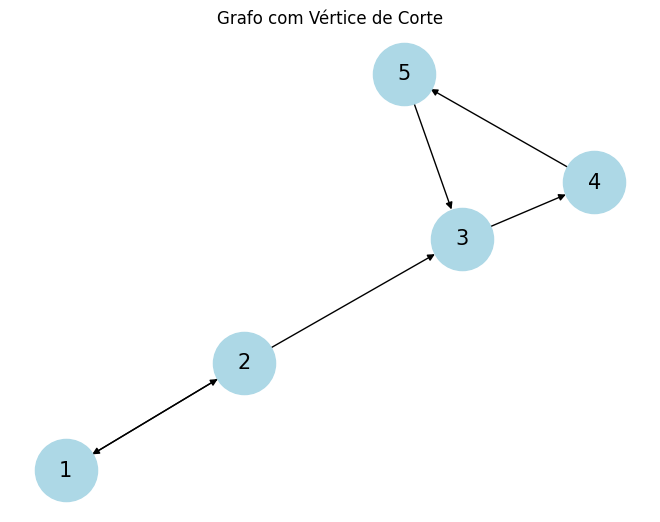

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar um grafo direcionado
G = nx.DiGraph()

# Adicionar nós e arestas
G.add_edges_from([
    (1, 2), (2, 1),  # CFC 1 (1 e 2 fortemente conectados)
    (2, 3),          # Vértice 2 conecta duas partes do grafo
    (3, 4), (4, 5), (5, 3)  # CFC 2 (3, 4, 5 fortemente conectados)
])

# Verificar as componentes fortemente conexas
strongly_connected = list(nx.strongly_connected_components(G))
print("Componentes fortemente conexas:", strongly_connected)

# Verificar as componentes fracamente conexas
weakly_connected = list(nx.weakly_connected_components(G))
print("Componentes fracamente conexas:", weakly_connected)

# Detectar vértices de corte no grafo (considerando o grafo como não direcionado)
articulation_points = list(nx.articulation_points(G.to_undirected()))
print("Vértices de corte:", articulation_points)

# Desenhar o grafo
pos = nx.spring_layout(G)  # Layout para uma visualização agradável
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=2000, font_size=15)
plt.title("Grafo com Vértice de Corte")
plt.show()


In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar um grafo direcionado
G = nx.DiGraph()

# Adicionar nós e arestas
G.add_edges_from([
    (1, 2), (2, 1),  # CFC 1 (1 e 2 fortemente conectados)
    (2, 3),          # Vértice 2 conecta duas partes do grafo
    (3, 4), (4, 5), (5, 3)  # CFC 2 (3, 4, 5 fortemente conectados)
])

# Detectar vértices de corte (considerando o grafo como não direcionado)
articulation_points = list(nx.articulation_points(G.to_undirected()))
print("Vértices de corte:", articulation_points)

# Função para desenhar o grafo com tamanho ajustado
def draw_graph(G, title):
    plt.figure(figsize=(6, 4))  # Reduzir o tamanho da figura


Vértices de corte: [3, 2]


Vértices de corte: [3, 2]


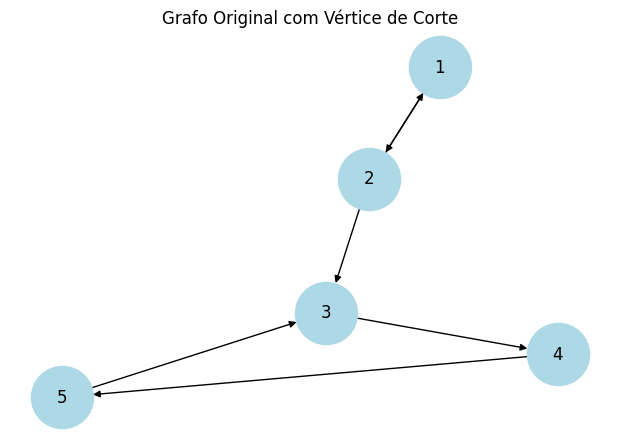

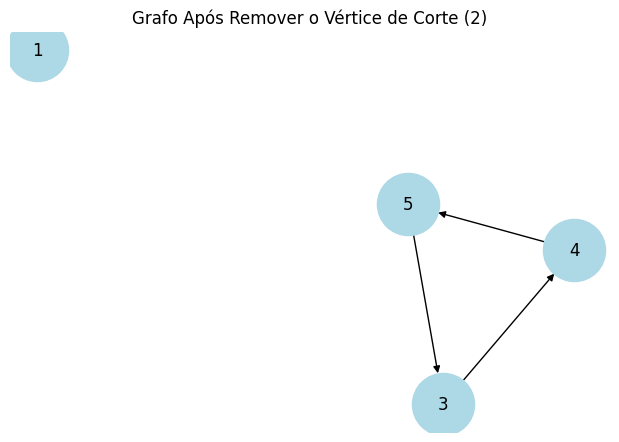

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar um grafo direcionado
G = nx.DiGraph()

# Adicionar nós e arestas
G.add_edges_from([
    (1, 2), (2, 1),  # CFC 1 (1 e 2 fortemente conectados)
    (2, 3),          # Vértice 2 conecta duas partes do grafo
    (3, 4), (4, 5), (5, 3)  # CFC 2 (3, 4, 5 fortemente conectados)
])

# Detectar vértices de corte (considerando o grafo como não direcionado)
articulation_points = list(nx.articulation_points(G.to_undirected()))
print("Vértices de corte:", articulation_points)

# Função para desenhar o grafo com tamanho ajustado
def draw_graph(G, title):
    plt.figure(figsize=(6, 4))  # Reduzir o tamanho da figura
    pos = nx.spring_layout(G)  # Layout para uma visualização agradável
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black', 
            node_size=2000, font_size=12)
    plt.title(title)
    plt.show()

# Desenhar o grafo original
draw_graph(G, "Grafo Original com Vértice de Corte")

# Remover o vértice de corte (nó 2)
G_removed = G.copy()
G_removed.remove_node(2)

# Desenhar o grafo após remover o vértice de corte
draw_graph(G_removed, "Grafo Após Remover o Vértice de Corte (2)")


In [62]:

origem = tranporte_ano[["CPF_CNPJ_Rem", "LatOrigem", "LongOrigem", "TpRem"]].rename(
    columns={
    'CPF_CNPJ_Rem': 'id_emp', 
    'LatOrigem': 'latitude', 
    'LongOrigem': 'longitude', 
    'TpRem': 'type'
})
destino = tranporte_ano[["CPF_CNPJ_Des", "LatDestino", "LongDestino", "TpDes"]].rename(
    columns={
    'CPF_CNPJ_Des': 'id_emp', 
    'LatDestino': 'latitude', 
    'LongDestino': 'longitude', 
    'TpDes': 'type'
})

nodes = pd.concat([origem, destino], ignore_index=True)
nodes.drop_duplicates("id_emp", inplace=True)

emp_type= {}
# nodes.to_csv("nodes.csv", index=False)
for i,node in nodes.iterrows():
  emp_type[str(node['id_emp'])] = node['type']


In [63]:
# CNPJ/CPFs das empresas importantes
importante_nodes = list(df_pto_outliers['CPF_CNPJ'])

# Componentes fracamente conexas
weakly_connected_components = list(nx.weakly_connected_components(G))

# Filtrando as componentes que possuem mais de uma empresa importante
result = [
    set(component) & set(importante_nodes)
    for component in weakly_connected_components
    if len(set(component) & set(importante_nodes)) > 1
]

# Número de componentes com mais de uma empresa importante
num_components_with_important = len(result)
print(f"Numero de componentes conexas com mais de uma empresa importante: {num_components_with_important}")

# Rodando o algoritmo get_timberflow para cada componente com mais de uma empresa importante
for comp in result:
    print(f"Componente: {comp}")
    
    # Filtrando o grafo para incluir apenas os nós da componente
    subgraph = G.subgraph(comp).copy()

    # Extraindo o tipo de empresa (emp_type) para o subgrafo
    emp_type_subgraph = {node: emp_type[node] for node in comp}
    
    # Rodando a função get_timberflow no subgrafo
    print("Calculando fluxo de madeira para esta componente:")
    get_timberflow(subgraph, emp_type_subgraph)
    print()


Numero de componentes conexas com mais de uma empresa importante: 2
Componente: {'11739425000133', '2411968000136', '19414279000188', '57686933000100', '173353000517', '4372478000101', '55903280000130', '1906760000125', '2877987000233', '56147184000171', '3028051000110', '60201662000151', '3767185000152', '1390039000125', '6337318000149', '7493220000143', '13007365000190', '4316368000114', '5282870000114', '421694000130', '5669339000107', '1589479000297', '453314000140', '10373419000142', '4385294000178', '2967595000184', '7445996000198', '5661374000171', '8580794000111', '5638059000123', '11094371000104', '13722177000224', '4223482000108', '44663409000163', '10198258000106', '26416168000176', '9321572000147', '10700382000110', '2928483000114', '9943001000144', '55817449000139', '8021370000621', '59229278000188', '8444391000145', '9341951000107', '67514877000171', '3407641000153', '37547122000102', '36407542000120', '21260928000185', '67682021000105', '72559586000130', '852080000103', 

ZeroDivisionError: float division by zero